In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.signal import correlate
from scipy.stats import pearsonr
import os

以下のセルでEKF_Simulation_AllData.csvにカラム名を付与してください

In [2]:
# path = "new50"
# column_names = [
#     'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
#     'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
#     'u1_s', 'u2_s',  # s_uHistory
#     'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
#     'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
#     'u1_l', 'u2_l'  # l_uHistory
# ]
# df = pd.read_csv(path, names=column_names, header=None)
# df.to_csv(path,index=False)

In [3]:
# # データフォルダーのパス
# folder_path = "new50"

# column_names = [
#     'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
#     'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
#     'u1_s', 'u2_s'  # s_uHistory
#     # 'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
#     # 'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
#     # 'u1_l', 'u2_l'  # l_uHistory
# ]
# # フォルダー内のCSVファイルを取得
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# # 各CSVファイルにヘッダーを追加
# for file_name in csv_files:
#     file_path = os.path.join(folder_path, file_name)

#     # CSVデータの読み込み（ヘッダーなしで読み込む）
#     df = pd.read_csv(file_path, header=None, names=column_names)

#     # ヘッダー付きでCSVを上書き保存
#     df.to_csv(file_path, index=False)

#     print(f"Updated header for: {file_name}")


次に「use_makecop.m」を実行してcopを計算してください
次にdata\EKF_Simulation_AllData_with_COP.csvを使用してcomのデータを取得します

In [4]:
df = pd.read_csv("data/AllData_takami_60s_with_COP.csv")

system_params = {
    'm1': 28.00,   # Mass of the first segment (leg)
    'm2': 53.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.88,    # Length of the second segment (trunk)
    'com1': 0.58,  # Distance to CoM of the first segment
    'com2': 0.32,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Function to calculate CoM
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # Convert to radians
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # Calculate CoM positions
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    # Ensure it returns a Pandas Series with correct length
    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'],row['q2_s_true'], system_params), axis=1)
df[['com_x_l', 'com_z_l']] = df.apply(lambda row: calculate_com(row['q1_l_true'],row['q2_l_true'], system_params), axis=1)

df[['dcom_x_s', 'dcom_z_s']] = df[['com_x_s', 'com_z_s']].diff().fillna(0)
df[['dcom_x_l', 'dcom_z_l']] = df[['com_x_l', 'com_z_l']].diff().fillna(0)

df[['ddcom_x_s', 'ddcom_z_s']] = df[['dcom_x_s', 'dcom_z_s']].diff().fillna(0)
df[['ddcom_x_l', 'ddcom_z_l']] = df[['dcom_x_l', 'dcom_z_l']].diff().fillna(0)

df[['dCOP_s', 'dCOP_l']] = df[['COP_s', 'COP_l']].diff().fillna(0)
df[['ddCOP_s', 'ddCOP_l']] = df[['dCOP_s', 'dCOP_l']].diff().fillna(0)

In [5]:
df.to_csv("data/AllData_takami_60s_with_COP_COM.csv",index = False)

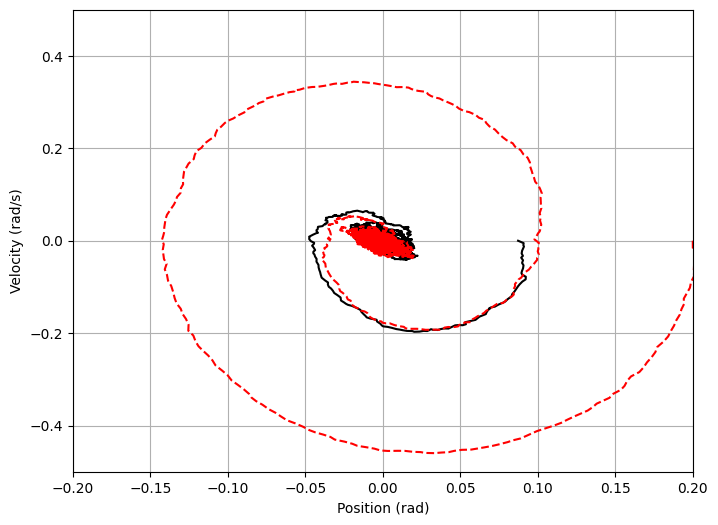

In [56]:
# グラフの作成
plt.figure(figsize=(8, 6))

# 実線（青色）
plt.plot(df["q1_s_true"], df["dq1_s_true"], color="black")

# 破線（赤色）
plt.plot(df["q1_l_true"], df["dq1_l_true"], linestyle="--", color="red")

# 軸の範囲を正しく設定（関数を使う）
plt.xlim(-0.2, 0.2)
plt.ylim(-0.5, 0.5)
plt.xlabel('Position (rad)')
plt.ylabel('Velocity (rad/s)')
# グリッドを追加（必要なら）
plt.grid(True)

# グラフを表示
plt.show()

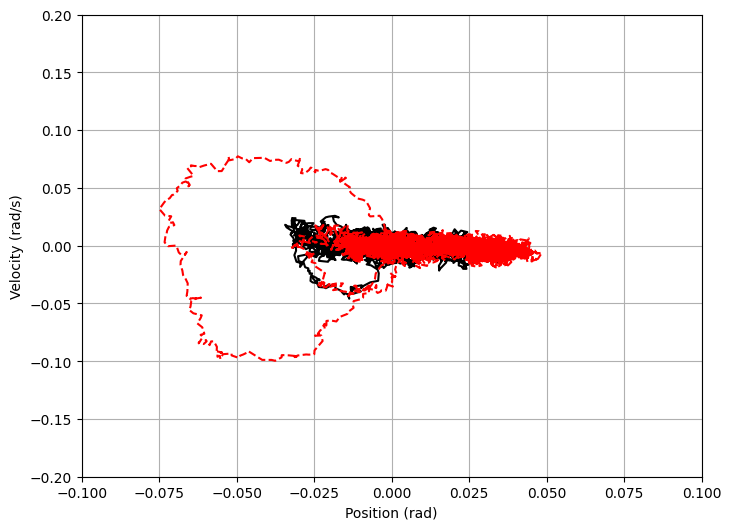

In [54]:
# グラフの作成
plt.figure(figsize=(8, 6))

# 実線（青色）
plt.plot(df["q2_s_true"], df["dq2_s_true"], color="black")

# 破線（赤色）
plt.plot(df["q2_l_true"], df["dq2_l_true"], linestyle="--", color="red")

# 軸の範囲を正しく設定（関数を使う）
plt.xlim(-0.1, 0.1)
plt.ylim(-0.2, 0.2)
plt.xlabel('Position (rad)')
plt.ylabel('Velocity (rad/s)')
# グリッドを追加（必要なら）
plt.grid(True)

# グラフを表示
plt.show()

以下のセルでddqを作成します

In [7]:
def compute_net_torque(t, x, u, params):
    # Unpack parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']

    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Unpack states
    q1, q2, dq1, dq2 = x

    q1_new = q1 + np.pi / 2

    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    s1 = np.sin(q1_new)
    s2 = np.sin(q2)
    c1 = np.cos(q1_new)
    c2 = np.cos(q2)
    c12 = np.cos(q1_new + q2)

    # Compute the Mass Matrix (M)
    M11 = a + 2 * b * c2
    M12 = d + b * c2
    M = np.array([[M11, M12],
                  [M12, d]])

    # Compute the Coriolis Matrix (C)
    C = np.array([
        [-b * s2 * dq2, -b * s2 * (dq1 + dq2)],
        [b * s2 * dq2, 0]
    ])

    # Compute the Gravity Vector (G)
    G1 = -g * ((m1 * r1 + m2 * L1) * c1 + m2 * r2 * c12)
    G2 = -g * m2 * r2 * c12
    G = np.array([G1, G2])

    # Inverse of the Mass Matrix (M)
    M_inv = np.linalg.inv(M + 1e-6 * np.eye(2))

    # Compute net torque
    NET_torque = u - (C @ np.array([dq1, dq2]) + G)

        # Compute M_inv * u
    M_inv_u = M_inv @ u

    # Compute M_inv * (-G)
    M_inv_neg_G = M_inv @ (-G)

    M_inv_C = M_inv @ C @ np.array([dq1, dq2])
    

    # Torque components
    T_a = np.array([u[0], 0])  # Torque applied at the ankle only
    T_h = np.array([0, u[1]])  # Torque applied at the hip only

    # Gravity components
    G_a = np.array([G1, 0])  # Gravity contribution from ankle
    G_h = np.array([0, G2])  # Gravity contribution from hip

    # Compute ddq components
    ddq_Ta = M_inv @ T_a  # Contribution of T_a
    ddq_Th = M_inv @ T_h  # Contribution of T_h
    ddq_Ga = M_inv @ (-G_a)  # Contribution of G_a
    ddq_Gh = M_inv @ (-G_h)  # Contribution of G_h

    return NET_torque, M_inv_u, M_inv_neg_G, ddq_Ta, ddq_Th, ddq_Ga, ddq_Gh, M_inv_C


def double_link_dynamics_takami(t, x, u, params):

    # Unpack parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']

    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Unpack states
    q1, q2, dq1, dq2 = x

    q1_new = q1 + np.pi / 2

    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    s1 = np.sin(q1_new)
    s2 = np.sin(q2)
    c1 = np.cos(q1_new)
    c2 = np.cos(q2)
    c12 = np.cos(q1_new + q2)

    # Compute the Mass Matrix (M)
    M11 = a + 2 * b * c2
    M12 = d + b * c2
    M = np.array([[M11, M12],
                  [M12, d]])

    # Compute the Coriolis Matrix (C)
    C = np.array([
        [-b * s2 * dq2, -b * s2 * (dq1 + dq2)],
        [b * s2 * dq2, 0]
    ])

    # Compute the Gravity Vector (G)
    G1 = -g * ((m1 * r1 + m2 * L1) * c1 + m2 * r2 * c12)
    G2 = -g * m2 * r2 * c12
    G = np.array([G1, G2])

    # Solve for angular accelerations
    ddq = np.linalg.solve(M + 1e-6 * np.eye(2), u - C @ np.array([dq1, dq2]) - G)

    # Return state derivatives
    dxdt = np.array([dq1, dq2, ddq[0], ddq[1]])

    return dxdt, -G

以下のセルでddq,G,NETtorqueを作成します

In [8]:
x_data = df[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']].values
u_data = df[['u1_s', 'u2_s']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで
dxdt_list = []
G_list = []
NET_torque = []
M_inv_u_list = []
M_inv_neg_G_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    
    dxdt,G = double_link_dynamics_takami(0, x_k, u_k_next, params)
    dxdt_list.append(dxdt)
    G_list.append(G)
    NET_torque.append(compute_net_torque(0,x_k, u_k_next, params)[0])

dxdt_array = np.array(dxdt_list)
G_array = np.array(G_list)
NET_torque_array = np.array(NET_torque)
df_dxdt = pd.DataFrame(dxdt_list, columns=['dq1', 'dq2', 'ddq1', 'ddq2'])
df_G = pd.DataFrame(G_list, columns=['G1', 'G2'])
df_NET_torque = pd.DataFrame(NET_torque, columns=['NET_torque1', 'NET_torque2'])

df['ddq1_s_true'] = df_dxdt['ddq1']
df['ddq2_s_true'] = df_dxdt['ddq2']
df['G1_s_true'] = df_G['G1']
df['G2_s_true'] = df_G['G2']
df['NET_torque1'] = df_NET_torque['NET_torque1']
df['NET_torque2'] = df_NET_torque['NET_torque2']

In [82]:
x_data = df[['q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true']].values
u_data = df[['u1_l', 'u2_l']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで
dxdt_list = []
G_list = []
NET_torque = []
M_inv_u_list = []
M_inv_neg_G_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    
    dxdt,G = double_link_dynamics_takami(0, x_k, u_k_next, params)
    dxdt_list.append(dxdt)
    G_list.append(G)
    NET_torque.append(compute_net_torque(0,x_k, u_k_next, params)[0])

dxdt_array = np.array(dxdt_list)
G_array = np.array(G_list)
NET_torque_array = np.array(NET_torque)
df_dxdt = pd.DataFrame(dxdt_list, columns=['dq1', 'dq2', 'ddq1', 'ddq2'])
df_G = pd.DataFrame(G_list, columns=['G1', 'G2'])
df_NET_torque = pd.DataFrame(NET_torque, columns=['NET_torque1', 'NET_torque2'])

df['ddq1_l_true'] = df_dxdt['ddq1']
df['ddq2_l_true'] = df_dxdt['ddq2']
df['G1_l_true'] = df_G['G1']
df['G2_l_true'] = df_G['G2']
df['NET_torque1_l'] = df_NET_torque['NET_torque1']
df['NET_torque2_l'] = df_NET_torque['NET_torque2']

In [127]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l', 'ddq1_s_true', 'ddq2_s_true',
       'G1_s_true', 'G2_s_true', 'NET_torque1', 'NET_torque2', 'com_angle_rad',
       'com_angle_deg', 'com_angular_velocity', 'com_angle_rad_l',
       'com_angular_velocity_l', 'com_angular_acceleration',
       'com_angular_acceleration_l', 'ddq1_l_true', 'ddq2_l_true', 'G1_l_true',
       'G2_l_true', 'NET_torque1_l', 'NET_torque2_l'],
      dtype='object')

In [129]:
df["dCOP_s"]

0       0.000000
1       0.005660
2      -0.002535
3       0.003118
4      -0.004091
          ...   
5996    0.000708
5997   -0.002412
5998    0.000687
5999    0.000575
6000    0.000786
Name: dCOP_s, Length: 6001, dtype: float64

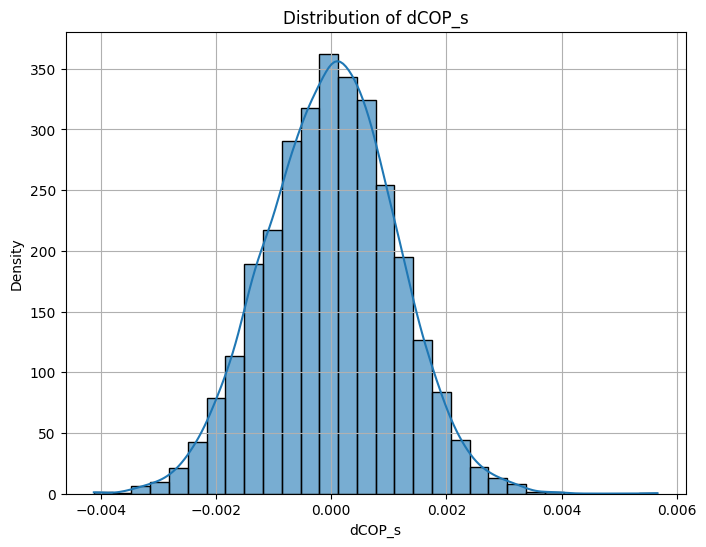

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ヒストグラムとカーネル密度推定（KDE）をプロット
plt.figure(figsize=(8, 6))
sns.histplot(df["dCOP_s"], bins=30, kde=True, stat="density", alpha=0.6, edgecolor='black')

# ラベルとタイトルの設定
plt.xlabel("dCOP_s")
plt.ylabel("Density")
plt.title("Distribution of dCOP_s")
plt.grid(True)

# プロットを表示
plt.show()

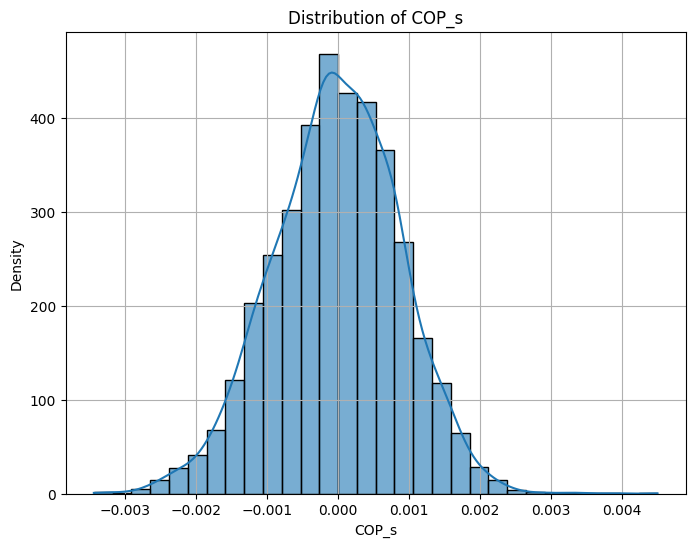

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ヒストグラムとカーネル密度推定（KDE）をプロット
plt.figure(figsize=(8, 6))
sns.histplot(df["COP_s"], bins=30, kde=True, stat="density", alpha=0.6, edgecolor='black')

# ラベルとタイトルの設定
plt.xlabel("COP_s")
plt.ylabel("Density")
plt.title("Distribution of COP_s")
plt.grid(True)

# プロットを表示
plt.show()

In [139]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

# ＿尖度（kurtosis）の計算
kurtosis_value = kurtosis(df["COP_s"], fisher=True)  # フィッシャーの定義（正規分布の尖度が0）

# 歪度（skewness）の計算
skewness_value = skew(df["COP_s"])

# 結果を出力
print(f"CoPのKurtosis (尖度): {kurtosis_value:.4f}")
print(f"CoPのSkewness (歪度): {skewness_value:.4f}")

# 尖度（kurtosis）の計算
kurtosis_value = kurtosis(df["dCOP_s"], fisher=True)  # フィッシャーの定義（正規分布の尖度が0）

# 歪度（skewness）の計算
skewness_value = skew(df["dCOP_s"])

# 結果を出力
print(f"dCoPのKurtosis (尖度): {kurtosis_value:.4f}")
print(f"dCoPのSkewness (歪度): {skewness_value:.4f}")

CoPのKurtosis (尖度): 0.1797
CoPのSkewness (歪度): -0.1022
dCoPのKurtosis (尖度): 0.0796
dCoPのSkewness (歪度): -0.0167


# Analytics from sasagawa

以下のセルで笹川の研究で行っている解析に必要なデータを作成します

In [9]:
def apply_butterworth_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

sasagawa= pd.DataFrame()
columns = ['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']
for column in columns:
    sasagawa[column] = apply_butterworth_filter(df[column], 0.5, 100)

In [10]:
x_data = sasagawa[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true']].values
u_data = df[['u1_s', 'u2_s']].values
params = {
    'm1': 28, 'm2': 53,
    'L1': 0.9, 'L2': 0.88,
    'I1': 9.21, 'I2': 5.35,
    'g': 9.81
}
num_steps = len(x_data) - 1  # k=0 から k=n-1 まで

M_inv_u_list = []
M_inv_neg_G_list = []
ddq_Ta_list = []
ddq_Th_list = []
ddq_Ga_list = []
ddq_Gh_list = []
M_inv_C_list = []

# 各時刻ステップで dxdt を計算
for k in range(num_steps):
    x_k = x_data[k]           # x[k]
    u_k_next = u_data[k + 1]   # u[k+1]
    
    M_inv_u_list.append(compute_net_torque(0,x_k, u_k_next, params)[1])
    M_inv_neg_G_list.append(compute_net_torque(0,x_k, u_k_next, params)[2])
    ddq_Ta_list.append(compute_net_torque(0,x_k, u_k_next, params)[3])
    ddq_Th_list.append(compute_net_torque(0,x_k, u_k_next, params)[4])
    ddq_Ga_list.append(compute_net_torque(0,x_k, u_k_next, params)[5])
    ddq_Gh_list.append(compute_net_torque(0,x_k, u_k_next, params)[6])
    M_inv_C_list.append(compute_net_torque(0,x_k, u_k_next, params)[7])


sasagawa = df[['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s']]

M_inv_u_array = np.array(M_inv_u_list)
M_inv_neg_G_array = np.array(M_inv_neg_G_list)
ddq_Ta_array = np.array(ddq_Ta_list)
ddq_Th_array = np.array(ddq_Th_list)
ddq_Ga_array = np.array(ddq_Ga_list)
ddq_Gh_array = np.array(ddq_Gh_list)
M_inv_C_array = np.array(M_inv_C_list)

df_M_inv_u = pd.DataFrame(M_inv_u_list, columns=['M_inv_u1', 'M_inv_u2'])
df_M_inv_neg_G = pd.DataFrame(M_inv_neg_G_list, columns=['M_inv_neg_G1', 'M_inv_neg_G2'])
df_ddq_Ta = pd.DataFrame(ddq_Ta_list, columns=['ddq_Ta1', 'ddq_Ta2'])
df_ddq_Th = pd.DataFrame(ddq_Th_list, columns=['ddq_Th1', 'ddq_Th2'])
df_ddq_Ga = pd.DataFrame(ddq_Ga_list, columns=['ddq_Ga1', 'ddq_Ga2'])
df_ddq_Gh = pd.DataFrame(ddq_Gh_list, columns=['ddq_Gh1', 'ddq_Gh2'])
df_M_inv_C = pd.DataFrame(M_inv_C_list, columns=['M_inv_C1', 'M_inv_C2'])

sasagawa['M_inv_u1'] = df_M_inv_u['M_inv_u1']
sasagawa['M_inv_u2'] = df_M_inv_u['M_inv_u2']
sasagawa['M_inv_neg_G1'] = df_M_inv_neg_G['M_inv_neg_G1']
sasagawa['M_inv_neg_G2'] = df_M_inv_neg_G['M_inv_neg_G2']
sasagawa['M_inv_C1'] = df_M_inv_C['M_inv_C1']
sasagawa['M_inv_C2'] = df_M_inv_C['M_inv_C2']
sasagawa['ddq_Ta1'] = df_ddq_Ta['ddq_Ta1']
sasagawa['ddq_Ta2'] = df_ddq_Ta['ddq_Ta2']
sasagawa['ddq_Th1'] = df_ddq_Th['ddq_Th1']
sasagawa['ddq_Th2'] = df_ddq_Th['ddq_Th2']
sasagawa['ddq_Ga1'] = df_ddq_Ga['ddq_Ga1']
sasagawa['ddq_Ga2'] = df_ddq_Ga['ddq_Ga2']
sasagawa['ddq_Gh1'] = df_ddq_Gh['ddq_Gh1']
sasagawa['ddq_Gh2'] = df_ddq_Gh['ddq_Gh2']
sasagawa['ddq_NETa1'] = sasagawa['ddq_Ta1'] + sasagawa['ddq_Ga1']
sasagawa['ddq_NETa2'] = sasagawa['ddq_Ta2'] + sasagawa['ddq_Ga2']
sasagawa['ddq_NETh1'] = sasagawa['ddq_Th1'] + sasagawa['ddq_Gh1']
sasagawa['ddq_NETh2'] = sasagawa['ddq_Th2'] + sasagawa['ddq_Gh2']
sasagawa['ddq1'] = sasagawa['ddq_NETa1'] + sasagawa['ddq_NETh1']
sasagawa['ddq2'] = sasagawa['ddq_NETa2'] + sasagawa['ddq_NETh2']


/var/folders/_w/vvf_c7mn1ws64sscy_kpsf1c0000gq/T/ipykernel_99553/107354127.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sasagawa['M_inv_u1'] = df_M_inv_u['M_inv_u1']
/var/folders/_w/vvf_c7mn1ws64sscy_kpsf1c0000gq/T/ipykernel_99553/107354127.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sasagawa['M_inv_u2'] = df_M_inv_u['M_inv_u2']
/var/folders/_w/vvf_c7mn1ws64sscy_kpsf1c0000gq/T/ipykernel_99553/107354127.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [128]:
sasagawa.columns

Index(['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s',
       'M_inv_u1', 'M_inv_u2', 'M_inv_neg_G1', 'M_inv_neg_G2', 'M_inv_C1',
       'M_inv_C2', 'ddq_Ta1', 'ddq_Ta2', 'ddq_Th1', 'ddq_Th2', 'ddq_Ga1',
       'ddq_Ga2', 'ddq_Gh1', 'ddq_Gh2', 'ddq_NETa1', 'ddq_NETa2', 'ddq_NETh1',
       'ddq_NETh2', 'ddq1', 'ddq2'],
      dtype='object')

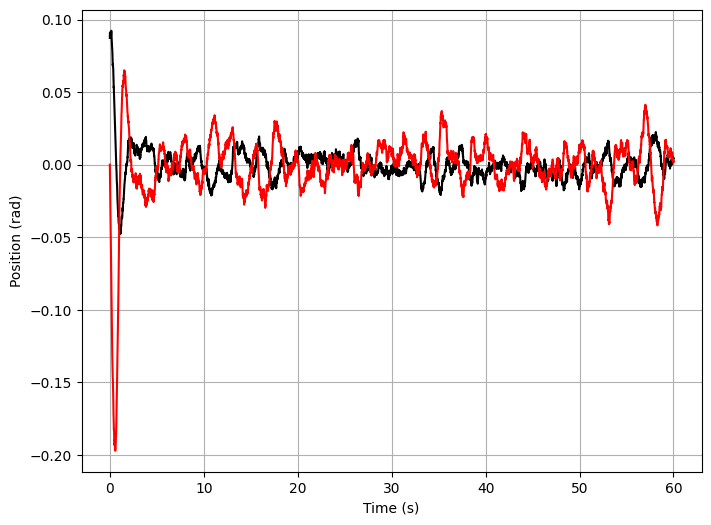

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# 時間軸の生成（index * ts）
time = df.index * 0.01  # ts = 0.01 秒なので時間に変換

# グラフの作成
plt.figure(figsize=(8, 6))

# 実線（黒色）
plt.plot(time, df["q1_s_true"], color="black", label="q1")

# 破線（赤色）
plt.plot(time, df["dq1_s_true"], color="red", label="dq1")

# 軸ラベル
plt.xlabel('Time (s)')
plt.ylabel('Position (rad)')
# x軸の目盛りを設定（0秒から60秒まで10秒間隔）
plt.xticks(np.arange(0, 61, 10))  # 0, 10, 20, ..., 60秒

# グリッドを追加
plt.grid(True)

# 凡例を追加（必要なら）
# plt.legend()

# グラフを表示
plt.show()


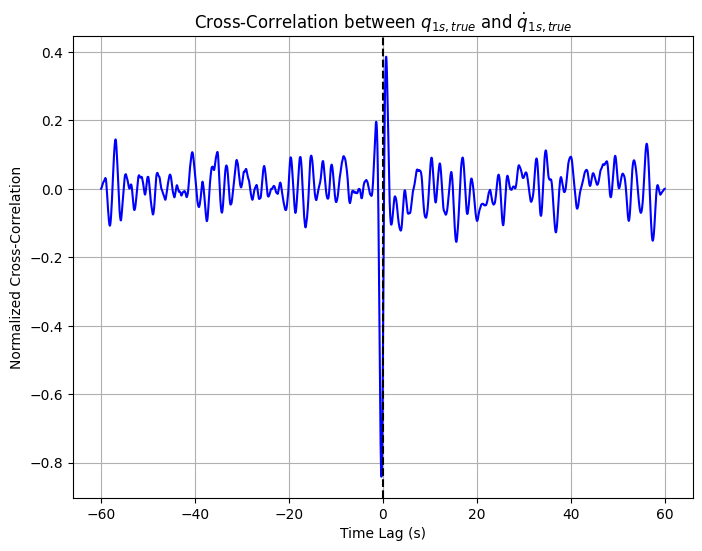

Cross-correlation at lag 0: -0.500


In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 時系列データを取得
q1_s_true = df["q1_s_true"]
dq1_s_true = df["dq1_s_true"]

# データを標準化（平均0、標準偏差1）
q1_s_true_norm = (q1_s_true - np.mean(q1_s_true)) / np.std(q1_s_true)
dq1_s_true_norm = (dq1_s_true - np.mean(dq1_s_true)) / np.std(dq1_s_true)

# クロス相関を計算（正規化済み）
cross_corr = np.correlate(q1_s_true_norm, dq1_s_true_norm, mode="full") / len(q1_s_true)

# ラグの範囲を計算
lags = np.arange(-len(q1_s_true) + 1, len(q1_s_true))

# クロス相関をプロット
plt.figure(figsize=(8, 6))
plt.plot(lags * 0.01, cross_corr, color="blue")  # 時間ラグを秒単位に変換
plt.xlabel("Time Lag (s)")
plt.ylabel("Normalized Cross-Correlation")
plt.title("Cross-Correlation between $q_{1s,true}$ and $\dot{q}_{1s,true}$")
plt.grid(True)
plt.axvline(0, color='black', linestyle='--')  # ラグ0の位置をマーク
plt.show()

# ラグ0の時の相関値を出力
lag_0_corr = cross_corr[len(q1_s_true) - 1]
print(f"Cross-correlation at lag 0: {lag_0_corr:.3f}")


In [123]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l', 'ddq1_s_true', 'ddq2_s_true',
       'G1_s_true', 'G2_s_true', 'NET_torque1', 'NET_torque2', 'com_angle_rad',
       'com_angle_deg', 'com_angular_velocity', 'com_angle_rad_l',
       'com_angular_velocity_l', 'com_angular_acceleration',
       'com_angular_acceleration_l', 'ddq1_l_true', 'ddq2_l_true', 'G1_l_true',
       'G2_l_true', 'NET_torque1_l', 'NET_torque2_l'],
      dtype='object')

In [12]:
sasagawa.columns

Index(['q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s',
       'M_inv_u1', 'M_inv_u2', 'M_inv_neg_G1', 'M_inv_neg_G2', 'M_inv_C1',
       'M_inv_C2', 'ddq_Ta1', 'ddq_Ta2', 'ddq_Th1', 'ddq_Th2', 'ddq_Ga1',
       'ddq_Ga2', 'ddq_Gh1', 'ddq_Gh2', 'ddq_NETa1', 'ddq_NETa2', 'ddq_NETh1',
       'ddq_NETh2', 'ddq1', 'ddq2'],
      dtype='object')

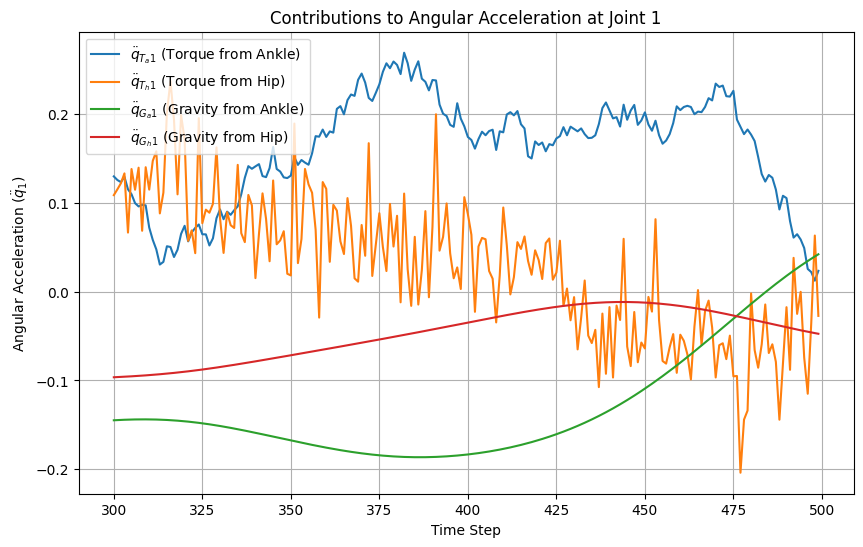

In [ ]:
import matplotlib.pyplot as plt
sampling_time = 0.01  # 1kHz
time = np.arange(len(sasagawa["ddq_Ta2"])) * sampling_time  # 200以降の時間

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_Ta1"][300:500], label=r'$\ddot{q}_{T_a1}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_Th1"][300:500], label=r'$\ddot{q}_{T_h1}$ (Torque from Hip)')
plt.plot(sasagawa["ddq_Ga1"][300:500], label=r'$\ddot{q}_{G_a1}$ (Gravity from Ankle)')
plt.plot(sasagawa["ddq_Gh1"][300:500], label=r'$\ddot{q}_{G_h1}$ (Gravity from Hip)')

# Add title and labels
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


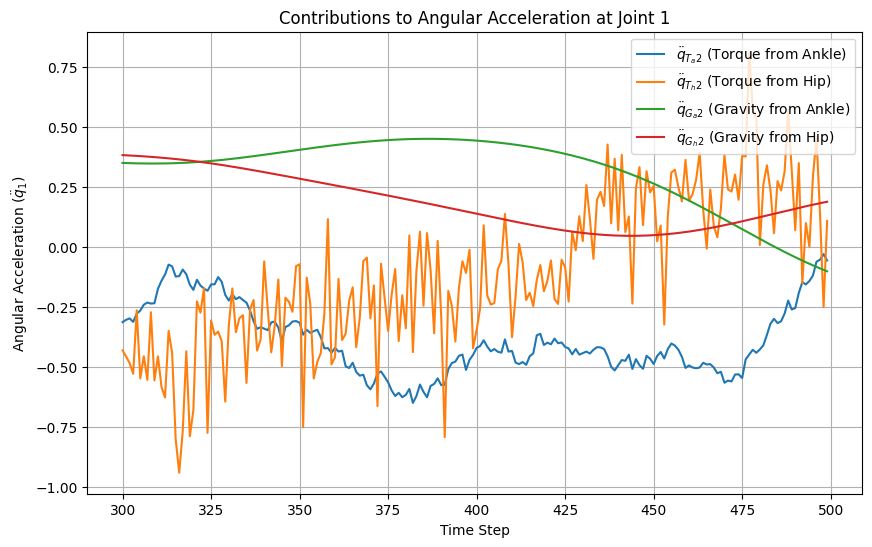

In [153]:
import matplotlib.pyplot as plt
# 時間ステップ（例: 1000Hzのサンプリングで0.001秒刻み）
sampling_time = 0.01  # 1kHz
time = np.arange(len(sasagawa["ddq_Ta2"])) * sampling_time  # 200以降の時間

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_Ta2"][300:500], label=r'$\ddot{q}_{T_a2}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_Th2"][300:500], label=r'$\ddot{q}_{T_h2}$ (Torque from Hip)')
plt.plot(sasagawa["ddq_Ga2"][300:500], label=r'$\ddot{q}_{G_a2}$ (Gravity from Ankle)')
plt.plot(sasagawa["ddq_Gh2"][300:500], label=r'$\ddot{q}_{G_h2}$ (Gravity from Hip)')

# Add title and labels
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## plot gain to hip

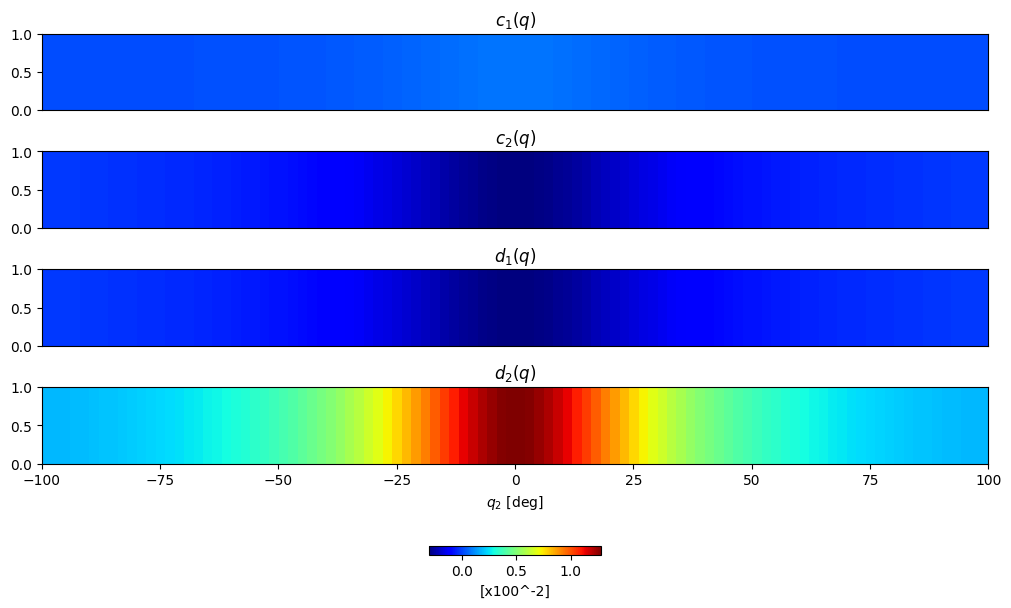

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Given physical parameters
params = {
    'm1': 28.00,   # Mass of the first segment (leg)
    'm2': 53.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.88,    # Length of the second segment (trunk)
    'com1': 0.58,  # Distance to CoM of the first segment
    'com2': 0.32,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Define range of hip joint angles qh (in degrees)
qh_degrees = np.linspace(-100, 100, 100)
qh_rad = np.deg2rad(qh_degrees)

# Preallocate storage for the coefficients
ca_values, ch_values, da_values, dh_values = [], [], [], []

# Compute the coefficients over the range of qh
for qh in qh_rad:
    m1, m2, L1, L2, I1, I2, g = params.values()
    r1 = 0.64 * L1
    r2 = 0.36 * L2

    # Inertia matrix elements
    a = I1 + I2 + m1 * r1**2 + m2 * (L1**2 + r2**2)
    b = m2 * L1 * r2
    d = I2 + m2 * r2**2

    # Compute the inertia matrix
    Theta = np.array([
        [a + 2 * b * np.cos(qh), d + b * np.cos(qh)],
        [d + b * np.cos(qh), d]
    ])

    # Compute inverse inertia matrix
    Theta_inv = np.linalg.inv(Theta)

    # Extract coefficients
    ca_values.append(Theta_inv[0, 0])  # Θ22/det(Θ)
    ch_values.append(Theta_inv[0, 1])  # -Θ12/det(Θ)
    da_values.append(Theta_inv[1, 0])  # -Θ21/det(Θ)
    dh_values.append(Theta_inv[1, 1])  # Θ11/det(Θ)

# Convert lists to numpy arrays
ca_values = np.array(ca_values)
ch_values = np.array(ch_values)
da_values = np.array(da_values)
dh_values = np.array(dh_values)

# Determine common color range for uniform plotting
vmin = min(ca_values.min(), ch_values.min(), da_values.min(), dh_values.min())
vmax = max(ca_values.max(), ch_values.max(), da_values.max(), dh_values.max())

# Create the figure
fig, ax = plt.subplots(4, 1, figsize=(10, 6), constrained_layout=True)

# Plot ca(q)
c1 = ax[0].imshow([ca_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[0].set_title(r'$c_1(q)$')
ax[0].set_xticks([])  # Hide x-axis ticks

# Plot ch(q)
c2 = ax[1].imshow([ch_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[1].set_title(r'$c_2(q)$')
ax[1].set_xticks([])

# Plot da(q)
c3 = ax[2].imshow([da_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[2].set_title(r'$d_1(q)$')
ax[2].set_xticks([])

# Plot dh(q)
c4 = ax[3].imshow([dh_values], aspect='auto', cmap='jet', extent=[-100, 100, 0, 1], vmin=vmin, vmax=vmax)
ax[3].set_title(r'$d_2(q)$')
ax[3].set_xlabel(r'$q_2$ [deg]')

# Add colorbar
cbar = fig.colorbar(c4, ax=ax, orientation='horizontal', fraction=0.02, pad=0.08)
cbar.set_label('[x100^-2]')

plt.show()

## plot T G

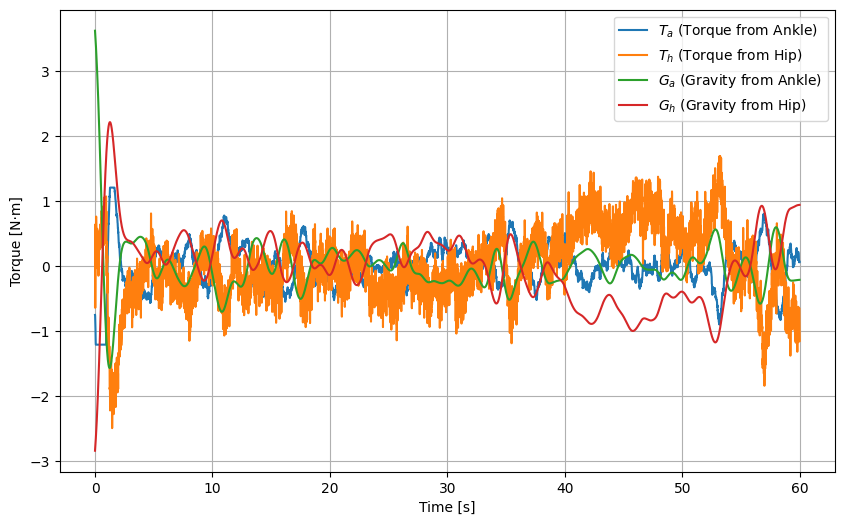

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# 時間ステップ（例: 1000Hzのサンプリングで0.001秒刻み）
sampling_time = 0.01  # 1kHz
time = np.arange(len(sasagawa["ddq_Ta2"])) * sampling_time  # 200以降の時間

# プロット
plt.figure(figsize=(10, 6))
plt.plot(time, sasagawa["ddq_Ta2"], label=r'${T_a}$ (Torque from Ankle)')
plt.plot(time, sasagawa["ddq_Th2"], label=r'${T_h}$ (Torque from Hip)')
plt.plot(time, sasagawa["ddq_Ga2"], label=r'${G_a}$ (Gravity from Ankle)')
plt.plot(time, sasagawa["ddq_Gh2"], label=r'${G_h}$ (Gravity from Hip)')

# 軸ラベルと凡例
plt.xlabel("Time [s]")
plt.ylabel("Torque [N·m]")
plt.legend()
plt.grid(True)

# プロット表示
plt.show()


## plot NET torque

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


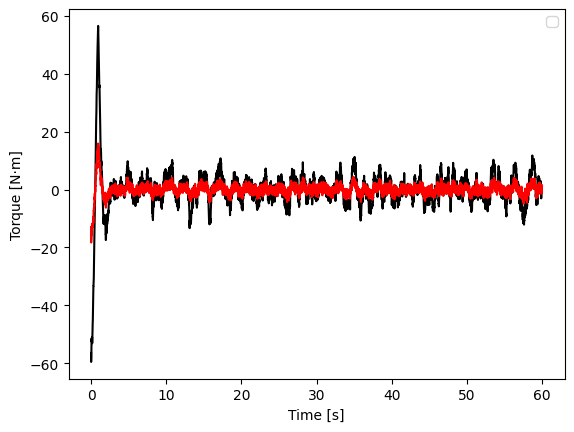

In [150]:
sampling_time = 0.01  # 1kHz
time = np.arange(len(df['NET_torque1'])) * sampling_time  # 200以降の時間

plt.plot(time, df['NET_torque1'],color="black")
plt.plot(time, df['NET_torque2'],color="r")

# 軸ラベルと凡例
plt.xlabel("Time [s]")
plt.ylabel("Torque [N·m]")
plt.legend()

In [17]:
def calculate_psd(signal, fs, fmin=0, fmax=2):
    """
    Calculate the PSD and normalize it in the 0-2 Hz range.
    
    Args:
        signal: The input signal (time-domain data).
        fs: Sampling frequency in Hz.
        fmin, fmax: Frequency range for normalization.
    
    Returns:
        freqs: Frequency values.
        psd_normalized: PSD normalized in the 0-2 Hz band.
    """
    freqs, psd = welch(signal, fs=fs, nperseg=1024)  # Welch's method
    idx_band = (freqs >= fmin) & (freqs <= fmax)
    total_power_band = np.sum(psd[idx_band])  # Total power in the 0-2 Hz band
    psd_normalized = psd / total_power_band  # Normalize PSD
    return freqs, psd_normalized

def calculate_mpf(freqs, psd_normalized):
    """
    Calculate the Mean Power Frequency (MPF).
    
    Args:
        freqs: Frequency values.
        psd_normalized: Normalized PSD.
    
    Returns:
        MPF: Mean Power Frequency.
    """
    numerator = np.sum(freqs * psd_normalized)  # Integral of f * P(f)
    denominator = np.sum(psd_normalized)       # Integral of P(f)
    mpf = numerator / denominator
    return mpf


In [18]:
# Example signals (replace with your NETa and NETh data)
net_torque_ankle = df["NET_torque1"]  # Replace with actual NETa data
net_torque_hip = df["NET_torque2"]    # Replace with actual NETh data

# Sampling frequency (replace with actual sampling frequency of your data)
fs = 100  # Example: 100 Hz

# Calculate PSD and MPF for NETa
freqs_ankle, psd_ankle = calculate_psd(net_torque_ankle, fs)
mpf_ankle = calculate_mpf(freqs_ankle, psd_ankle)

# Calculate PSD and MPF for NETh
freqs_hip, psd_hip = calculate_psd(net_torque_hip, fs)
mpf_hip = calculate_mpf(freqs_hip, psd_hip)

# Print results
print(f"MPF for NETa (Ankle): {mpf_ankle:.2f} Hz")
print(f"MPF for NETh (Hip): {mpf_hip:.2f} Hz")


MPF for NETa (Ankle): 1.68 Hz
MPF for NETh (Hip): 9.49 Hz


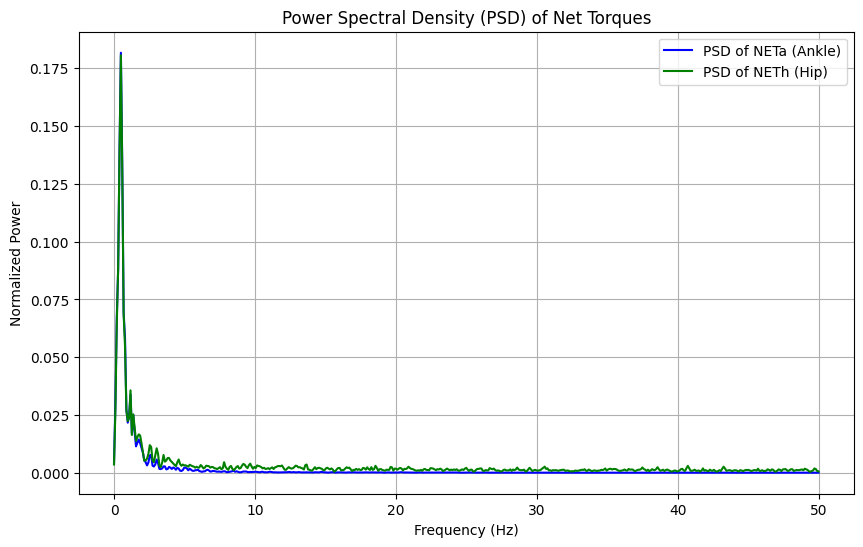

In [19]:
# Plot PSD for NETa and NETh
plt.figure(figsize=(10, 6))
plt.plot(freqs_ankle, psd_ankle, label='PSD of NETa (Ankle)', color='blue')
plt.plot(freqs_hip, psd_hip, label='PSD of NETh (Hip)', color='green')

# Add plot details
plt.title("Power Spectral Density (PSD) of Net Torques")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power")
plt.legend()
plt.grid(True)
plt.show()


## plot effects of two NET torques

In [20]:
def calculate_rms(data):
    return np.sqrt(np.mean(np.square(data)))

# Update lists from the DataFrame
ddq_NETa_ankle_list = sasagawa['ddq_NETa1'][:500].tolist()  # NETa contribution to ankle
ddq_NETa_hip_list = sasagawa['ddq_NETa2'][:500].tolist()    # NETa contribution to hip
ddq_NETh_ankle_list = sasagawa['ddq_NETh1'][:500].tolist()  # NETh contribution to ankle
ddq_NETh_hip_list = sasagawa['ddq_NETh2'][:500].tolist()    # NETh contribution to hip

# Calculate RMS for each contribution
rms_NETa_ankle = calculate_rms(ddq_NETa_ankle_list)
rms_NETh_ankle = calculate_rms(ddq_NETh_ankle_list)
rms_NETa_hip = calculate_rms(ddq_NETa_hip_list)
rms_NETh_hip = calculate_rms(ddq_NETh_hip_list)

# Print RMS results
print(f"RMS of q̈aNETa: {rms_NETa_ankle:.2f} ± {np.std(ddq_NETa_ankle_list) / np.sqrt(len(ddq_NETa_ankle_list)):.2f}°/s²")
print(f"RMS of q̈aNETh: {rms_NETh_ankle:.2f} ± {np.std(ddq_NETh_ankle_list) / np.sqrt(len(ddq_NETh_ankle_list)):.2f}°/s²")
print(f"RMS of q̈hNETa: {rms_NETa_hip:.2f} ± {np.std(ddq_NETa_hip_list) / np.sqrt(len(ddq_NETa_hip_list)):.2f}°/s²")
print(f"RMS of q̈hNETh: {rms_NETh_hip:.2f} ± {np.std(ddq_NETh_hip_list) / np.sqrt(len(ddq_NETh_hip_list)):.2f}°/s²")


RMS of q̈aNETa: 0.32 ± 0.01°/s²
RMS of q̈aNETh: 0.21 ± 0.01°/s²
RMS of q̈hNETa: 0.76 ± 0.03°/s²
RMS of q̈hNETh: 0.84 ± 0.04°/s²


In [21]:
def normalized_cross_correlation(x, y, fs):
    """
    Calculate the normalized cross-correlation between two signals.

    Args:
        x: First signal (array-like).
        y: Second signal (array-like).
        fs: Sampling frequency (Hz).

    Returns:
        lags: Array of time lags (in seconds).
        Rxy: Normalized cross-correlation values.
    """
    n = len(x)
    
    # Compute cross-correlation
    cross_corr = np.correlate(x - np.mean(x), y - np.mean(y), mode='full')
    
    # Normalize cross-correlation
    normalization_factor = np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2))
    Rxy = cross_corr / normalization_factor
    
    # Calculate lags (in seconds)
    lags = np.arange(-n + 1, n) / fs
    return lags, Rxy


In [22]:
# Sampling frequency (replace with actual value)
fs = 100  # Example: 100 Hz

# Signals (replace with actual DataFrame columns)
x = sasagawa['ddq_NETa1'][:6000].values  # Ankle torque contribution
y = sasagawa['ddq_NETh1'][:6000].values  # Hip torque contribution

# Compute normalized cross-correlation
lags, Rxy = normalized_cross_correlation(x, y, fs)

# Find the maximum correlation value and corresponding lag
max_corr = np.min(Rxy)
max_lag = lags[np.argmin(Rxy)]

print(f"Maximum Correlation: {max_corr:.3f}")
print(f"Lag at Maximum Correlation: {max_lag:.3f} s")


Maximum Correlation: -0.798
Lag at Maximum Correlation: 0.000 s


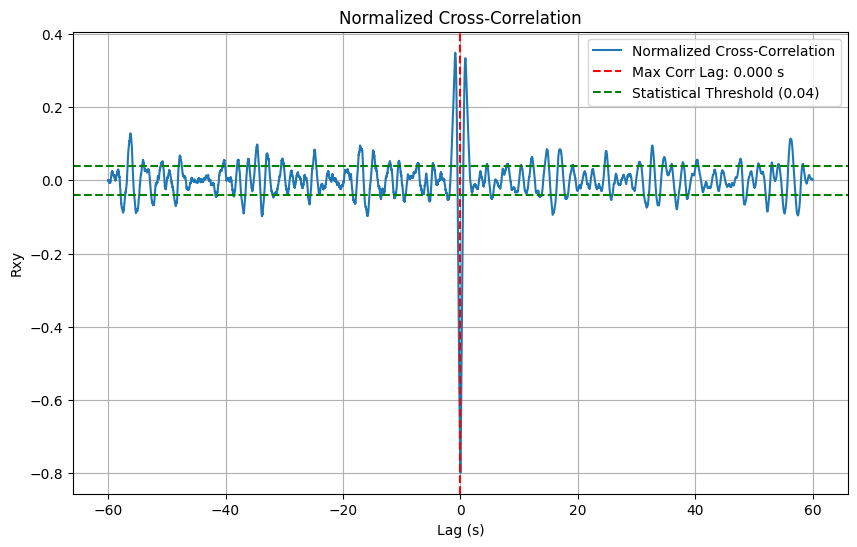

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lags, Rxy, label='Normalized Cross-Correlation')
plt.axvline(x=max_lag, color='red', linestyle='--', label=f'Max Corr Lag: {max_lag:.3f} s')
plt.axhline(y=0.04, color='green', linestyle='--', label='Statistical Threshold (0.04)')
plt.axhline(y=-0.04, color='green', linestyle='--')
plt.title("Normalized Cross-Correlation")
plt.xlabel("Lag (s)")
plt.ylabel("Rxy")
plt.legend()
plt.grid(True)
plt.show()


■ 最も負の相関係数: -0.804
   ⇒ そのラグ = 0.010 s, p = 0
■ ラグ0での相関係数: -0.798, p = 0


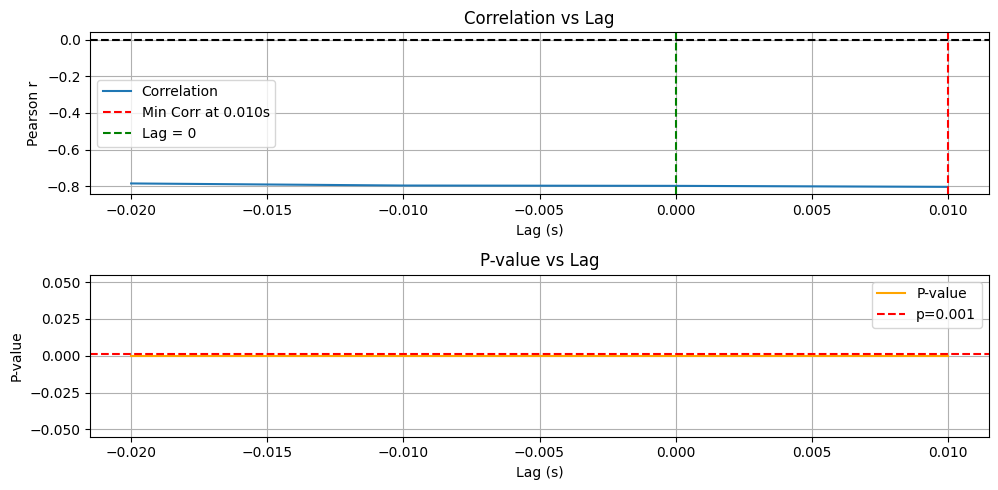

In [24]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def compute_correlation_with_lags(signal1, signal2, fs):
    """
    指定した2つの時系列信号の相関係数と P値を、-0.02s ~ +0.01s の範囲で算出する。
    1サンプルあたりの長さは 1/fs で計算。
    """
    # ラグのサンプル数（-0.02秒～+0.01秒）
    lag_samples_min = int(np.floor(-0.02 * fs))  # -0.02s → 例えば fs=100 なら -2 サンプル
    lag_samples_max = int(np.ceil( 0.01 * fs))   # +0.01s → 例えば fs=100 なら +1 サンプル
    
    # ラグ配列（秒単位）
    lags = np.arange(lag_samples_min, lag_samples_max + 1) / fs
    
    correlations = []
    p_values = []
    
    # 相関・p値を計算
    for lag in range(lag_samples_min, lag_samples_max + 1):
        if lag < 0:
            # signal2を左に |lag|サンプルずらす → 前方に zero-padding
            shifted_signal2 = np.pad(signal2[:lag], (abs(lag), 0), mode='constant')
            shifted_signal1 = signal1
        elif lag > 0:
            # signal1を左に lag サンプルずらす → 後方に zero-padding
            shifted_signal1 = np.pad(signal1[lag:], (0, lag), mode='constant')
            shifted_signal2 = signal2
        else:
            # lag=0 の場合はそのまま
            shifted_signal1 = signal1
            shifted_signal2 = signal2
        
        r, p = pearsonr(shifted_signal1, shifted_signal2)
        correlations.append(r)
        p_values.append(p)
    
    return np.array(correlations), np.array(p_values), lags

# -----------------------------
# サンプルデータ（適宜置き換えてください）
# 例：sasagawaという辞書に格納されている想定
signal1 = sasagawa['ddq_NETa1'][:6000]
signal2 = sasagawa['ddq_NETh1'][:6000]
fs = 100  # サンプリング周波数(Hz)
# -----------------------------

# 相関係数とP値の算出
correlations, p_values, lags = compute_correlation_with_lags(signal1, signal2, fs)

# 1) 相関係数が最小（最も負）になる箇所を探す
min_corr_value = np.min(correlations)
min_corr_index = np.argmin(correlations)
min_corr_lag   = lags[min_corr_index]
min_corr_p     = p_values[min_corr_index]

# 2) ラグが 0 のときの相関係数と p値を調べる
#    lags配列にちょうど0が含まれているはずなので検索
zero_lag_index = np.where(lags == 0)[0]
if len(zero_lag_index) > 0:
    zero_lag_index = zero_lag_index[0]
    zero_corr_value = correlations[zero_lag_index]
    zero_corr_p     = p_values[zero_lag_index]
else:
    # 万一含まれていない場合のための例外処理（基本的に起きない想定）
    zero_corr_value = None
    zero_corr_p     = None

# 結果を表示
print(f"■ 最も負の相関係数: {min_corr_value:.3f}")
print(f"   ⇒ そのラグ = {min_corr_lag:.3f} s, p = {min_corr_p:.4g}")
if zero_corr_value is not None:
    print(f"■ ラグ0での相関係数: {zero_corr_value:.3f}, p = {zero_corr_p:.4g}")
else:
    print("ラグ0が解析範囲内にありません")

# 以下、参考としてプロットを行う場合
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(lags, correlations, label='Correlation')
plt.axvline(min_corr_lag, color='red', linestyle='--',
            label=f'Min Corr at {min_corr_lag:.3f}s')
if zero_corr_value is not None:
    plt.axvline(0, color='green', linestyle='--', label='Lag = 0')
plt.axhline(0, color='black', linestyle='--')
plt.title('Correlation vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('Pearson r')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(lags, p_values, label='P-value', color='orange')
plt.axhline(0.001, color='red', linestyle='--', label='p=0.001')
plt.title('P-value vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


■ 最も負の相関係数: -0.804
   ⇒ そのラグ = 0.010 s, p = 0
■ ラグ0での相関係数: -0.798, p = 0


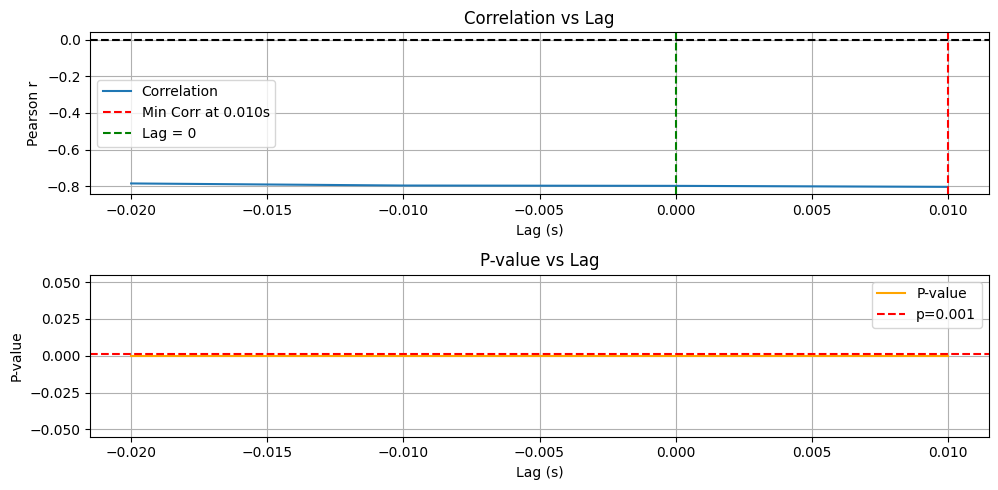

In [25]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def compute_correlation_with_lags(signal1, signal2, fs):
    """
    指定した2つの時系列信号の相関係数と P値を、-0.02s ~ +0.01s の範囲で算出する。
    1サンプルあたりの長さは 1/fs で計算。
    """
    # ラグのサンプル数（-0.02秒～+0.01秒）
    lag_samples_min = int(np.floor(-0.02 * fs))  # -0.02s → 例えば fs=100 なら -2 サンプル
    lag_samples_max = int(np.ceil( 0.01 * fs))   # +0.01s → 例えば fs=100 なら +1 サンプル
    
    # ラグ配列（秒単位）
    lags = np.arange(lag_samples_min, lag_samples_max + 1) / fs
    
    correlations = []
    p_values = []
    
    # 相関・p値を計算
    for lag in range(lag_samples_min, lag_samples_max + 1):
        if lag < 0:
            # signal2を左に |lag|サンプルずらす → 前方に zero-padding
            shifted_signal2 = np.pad(signal2[:lag], (abs(lag), 0), mode='constant')
            shifted_signal1 = signal1
        elif lag > 0:
            # signal1を左に lag サンプルずらす → 後方に zero-padding
            shifted_signal1 = np.pad(signal1[lag:], (0, lag), mode='constant')
            shifted_signal2 = signal2
        else:
            # lag=0 の場合はそのまま
            shifted_signal1 = signal1
            shifted_signal2 = signal2
        
        r, p = pearsonr(shifted_signal1, shifted_signal2)
        correlations.append(r)
        p_values.append(p)
    
    return np.array(correlations), np.array(p_values), lags

# -----------------------------
# サンプルデータ（適宜置き換えてください）
# 例：sasagawaという辞書に格納されている想定
signal1 = sasagawa['ddq_NETa2'][:6000]
signal2 = sasagawa['ddq_NETh2'][:6000]
fs = 100  # サンプリング周波数(Hz)
# -----------------------------

# 相関係数とP値の算出
correlations, p_values, lags = compute_correlation_with_lags(signal1, signal2, fs)

# 1) 相関係数が最小（最も負）になる箇所を探す
min_corr_value = np.min(correlations)
min_corr_index = np.argmin(correlations)
min_corr_lag   = lags[min_corr_index]
min_corr_p     = p_values[min_corr_index]

# 2) ラグが 0 のときの相関係数と p値を調べる
#    lags配列にちょうど0が含まれているはずなので検索
zero_lag_index = np.where(lags == 0)[0]
if len(zero_lag_index) > 0:
    zero_lag_index = zero_lag_index[0]
    zero_corr_value = correlations[zero_lag_index]
    zero_corr_p     = p_values[zero_lag_index]
else:
    # 万一含まれていない場合のための例外処理（基本的に起きない想定）
    zero_corr_value = None
    zero_corr_p     = None

# 結果を表示
print(f"■ 最も負の相関係数: {min_corr_value:.3f}")
print(f"   ⇒ そのラグ = {min_corr_lag:.3f} s, p = {min_corr_p:.4g}")
if zero_corr_value is not None:
    print(f"■ ラグ0での相関係数: {zero_corr_value:.3f}, p = {zero_corr_p:.4g}")
else:
    print("ラグ0が解析範囲内にありません")

# 以下、参考としてプロットを行う場合
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(lags, correlations, label='Correlation')
plt.axvline(min_corr_lag, color='red', linestyle='--',
            label=f'Min Corr at {min_corr_lag:.3f}s')
if zero_corr_value is not None:
    plt.axvline(0, color='green', linestyle='--', label='Lag = 0')
plt.axhline(0, color='black', linestyle='--')
plt.title('Correlation vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('Pearson r')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(lags, p_values, label='P-value', color='orange')
plt.axhline(0.001, color='red', linestyle='--', label='p=0.001')
plt.title('P-value vs Lag')
plt.xlabel('Lag (s)')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


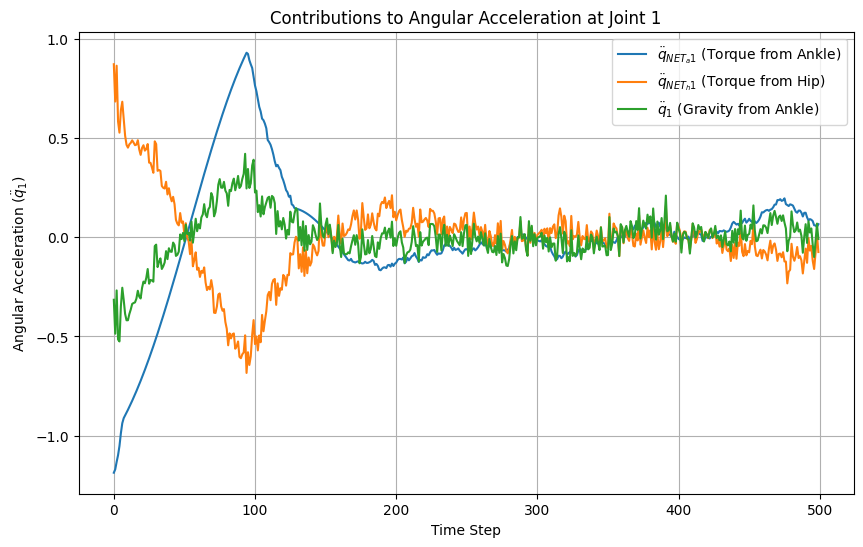

In [26]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_NETa1"][:500], label=r'$\ddot{q}_{NET_a1}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_NETh1"][:500], label=r'$\ddot{q}_{NET_h1}$ (Torque from Hip)')
plt.plot(sasagawa["ddq1"][:500], label=r'$\ddot{q}_1$ (Gravity from Ankle)')

# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


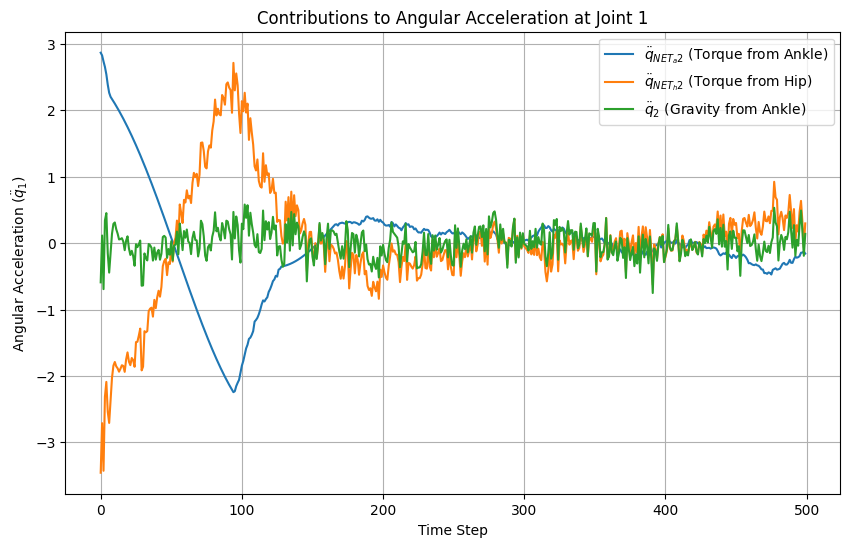

In [27]:
import matplotlib.pyplot as plt

# Plot the components with legends
plt.figure(figsize=(10, 6))
plt.plot(sasagawa["ddq_NETa2"][:500], label=r'$\ddot{q}_{NET_a2}$ (Torque from Ankle)')
plt.plot(sasagawa["ddq_NETh2"][:500], label=r'$\ddot{q}_{NET_h2}$ (Torque from Hip)')
plt.plot(sasagawa["ddq2"][:500], label=r'$\ddot{q}_2$ (Gravity from Ankle)')

# Add title and labels
plt.title("Contributions to Angular Acceleration at Joint 1")
plt.xlabel("Time Step")
plt.ylabel("Angular Acceleration ($\ddot{q}_1$)")

# Add legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


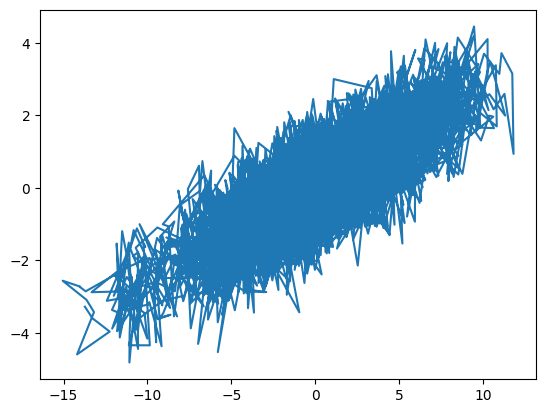

In [28]:
# plt.plot(df.index[200:], df['NET_torque1'][200:],color="black")/
plt.plot(df['NET_torque1'][200:], df['NET_torque2'][200:])

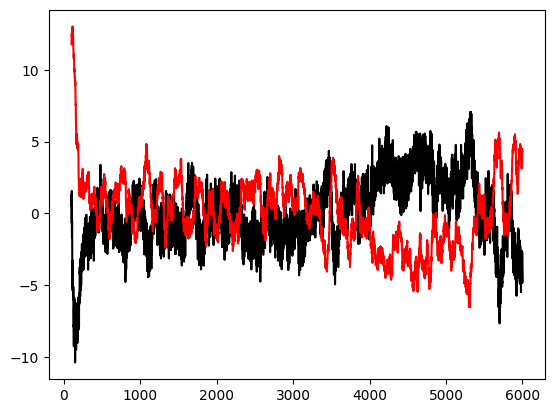

In [29]:
plt.plot(df.index[100:], df['u2_s'][100:], label='u1_s',color="black")
plt.plot(df.index[100:], df['G2_s_true'][100:], label='u1_l',color="r")

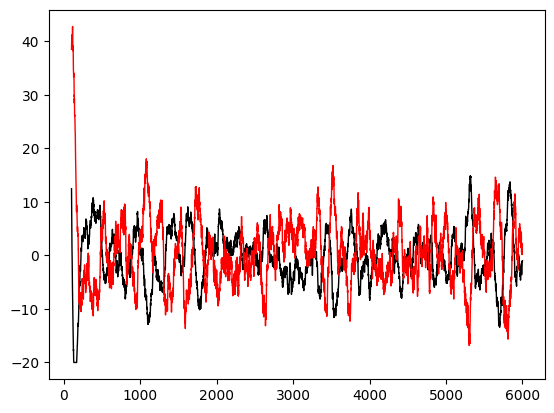

In [30]:
plt.plot(df.index[100:], df['u1_s'][100:], label='u1_s',color="black",linewidth=1)
plt.plot(df.index[100:], df['G1_s_true'][100:], label='u1_l',color="r",linewidth=1)

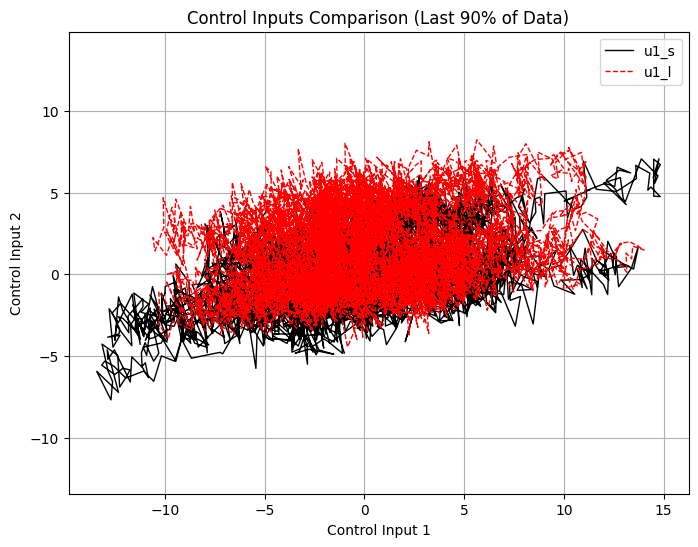

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# データフレーム df が存在することを確認してください
if 'df' in locals():
    # データの後半90%を取得
    start_index = int(len(df) * 0.1)  # 先頭10%をスキップ
    df_subset = df.iloc[start_index:]

    # データの取得
    u1_s = df_subset['u1_s'].values
    u2_s = df_subset['u2_s'].values
    u1_l = df_subset['u1_l'].values
    u2_l = df_subset['u2_l'].values

    # すべてのデータを結合して90%範囲を計算
    all_data = np.concatenate([u1_s, u2_s, u1_l, u2_l])
    percentile_5 = np.percentile(all_data, 0)
    percentile_95 = np.percentile(all_data, 100)

    # プロット
    plt.figure(figsize=(8, 6))
    plt.plot(u1_s, u2_s, label='u1_s', color="black", linewidth=1)
    plt.plot(u1_l, u2_l, label='u1_l', linestyle="--", color="r", linewidth=1)

    # y軸の範囲を設定（全体の90%のデータ範囲）
    plt.ylim(percentile_5, percentile_95)

    # ラベルと凡例
    plt.xlabel('Control Input 1')
    plt.ylabel('Control Input 2')
    plt.legend()
    plt.title('Control Inputs Comparison (Last 90% of Data)')

    # グリッド表示
    plt.grid(True)

    # グラフの表示
    plt.show()
else:
    print("データフレーム 'df' が存在しません。データを提供してください。")


Text(0, 0.5, 'tau2(N.m)')

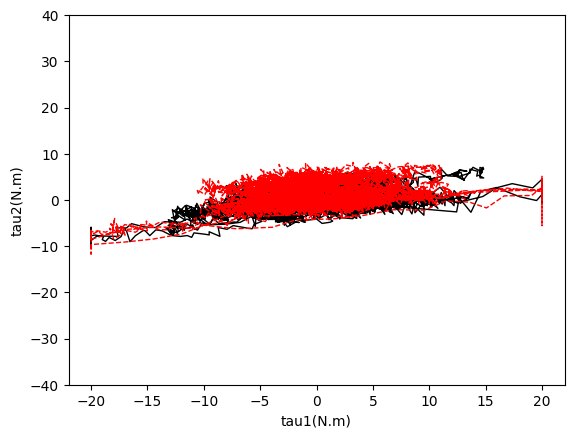

In [45]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)

plt.xlabel('tau1(N.m)')
plt.ylabel('tau2(N.m)')

# morasso part

In [74]:
import numpy as np

# 角度を計算（前のステップのコードを使用）
df["com_angle_rad"] = np.arctan2(df["com_x_s"], df["com_z_s"])
df["com_angle_rad_l"] = np.arctan2(df["com_x_l"], df["com_z_l"])


# 時間間隔（サンプリング周期 ts = 0.01s）
ts = 0.01  

# 角速度（有限差分で近似）
df["com_angular_velocity"] = np.gradient(df["com_angle_rad"], ts)
df["com_angular_velocity_l"] = np.gradient(df["com_angle_rad_l"], ts)

df["com_angular_acceleration"] = np.gradient(df["com_angular_velocity"], ts)
df["com_angular_acceleration_l"] = np.gradient(df["com_angular_velocity_l"], ts)



In [79]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l', 'ddq1_s_true', 'ddq2_s_true',
       'G1_s_true', 'G2_s_true', 'NET_torque1', 'NET_torque2', 'com_angle_rad',
       'com_angle_deg', 'com_angular_velocity', 'com_angle_rad_l',
       'com_angular_velocity_l', 'com_angular_acceleration',
       'com_angular_acceleration_l'],
      dtype='object')

In [91]:
import numpy as np
import pandas as pd

# RoV（Range of Variation, 90%のデータを含む範囲）の上限・下限を計算する関数
def compute_rov_limits(data):
    data = data[500:].dropna()  # 欠損値を除外
    lower_bound = np.percentile(data, 5)  # 5%パーセンタイル（下限）
    upper_bound = np.percentile(data, 95) # 95%パーセンタイル（上限）
    return lower_bound, upper_bound

# 各データの RoV の上限・下限を計算
rov_limits = {
    "q1_s_true_lower": None, "q1_s_true_upper": None,
    "q2_s_true_lower": None, "q2_s_true_upper": None,
    "dq1_s_true_lower": None, "dq1_s_true_upper": None,
    "dq2_s_true_lower": None, "dq2_s_true_upper": None,
    "q1_l_true_lower": None, "q1_l_true_upper": None,
    "q2_l_true_lower": None, "q2_l_true_upper": None,
    "dq1_l_true_lower": None, "dq1_l_true_upper": None,
    "dq2_l_true_lower": None, "dq2_l_true_upper": None,
}

# 各データに対して上限・下限を計算
for key in ["q1_s_true", "q2_s_true", "dq1_s_true", "dq2_s_true",
            "q1_l_true", "q2_l_true", "dq1_l_true", "dq2_l_true",
            "ddq1_s_true", "ddq2_s_true", "ddq1_l_true", "ddq2_l_true"]:
    lower, upper = compute_rov_limits(df[key])
    rov_limits[f"{key}_lower"] = lower
    rov_limits[f"{key}_upper"] = upper

# 結果をデータフレーム化
rov_df = pd.DataFrame([rov_limits])

# RoV の上限・下限を表示
print(rov_df)


   q1_s_true_lower  q1_s_true_upper  q2_s_true_lower  q2_s_true_upper  \
0        -0.013132         0.012098        -0.016649         0.025081   

   dq1_s_true_lower  dq1_s_true_upper  dq2_s_true_lower  dq2_s_true_upper  \
0         -0.019756          0.021369         -0.009365          0.009788   

   q1_l_true_lower  q1_l_true_upper  ...  dq2_l_true_lower  dq2_l_true_upper  \
0         -0.01462         0.009832  ...         -0.010677          0.007585   

   ddq1_s_true_lower  ddq1_s_true_upper  ddq2_s_true_lower  ddq2_s_true_upper  \
0          -0.104267            0.10612          -0.335375           0.329945   

   ddq1_l_true_lower  ddq1_l_true_upper  ddq2_l_true_lower  ddq2_l_true_upper  
0          -0.096785           0.105345          -0.333885           0.333404  

[1 rows x 24 columns]


In [92]:
rov_df

,q1_s_true_lower,q1_s_true_upper,q2_s_true_lower,q2_s_true_upper,dq1_s_true_lower,dq1_s_true_upper,dq2_s_true_lower,dq2_s_true_upper,q1_l_true_lower,q1_l_true_upper,...,dq2_l_true_lower,dq2_l_true_upper,ddq1_s_true_lower,ddq1_s_true_upper,ddq2_s_true_lower,ddq2_s_true_upper,ddq1_l_true_lower,ddq1_l_true_upper,ddq2_l_true_lower,ddq2_l_true_upper
0,-0.013132,0.012098,-0.016649,0.025081,-0.019756,0.021369,-0.009365,0.009788,-0.01462,0.009832,...,-0.010677,0.007585,-0.104267,0.10612,-0.335375,0.329945,-0.096785,0.105345,-0.333885,0.333404


Text(0, 0.5, 'deg/s')

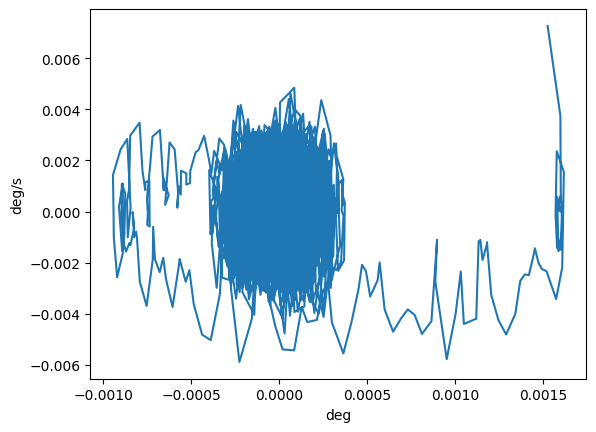

In [71]:
plt.plot(df['com_angle_rad'], df['com_angular_velocity'], label='u1_s')
plt.xlabel('deg')
plt.ylabel('deg/s')


Text(0, 0.5, 'deg/s')

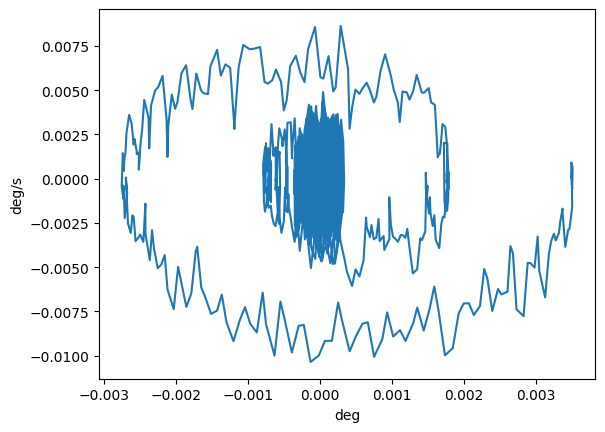

In [73]:
plt.plot(df['com_angle_rad_l'], df['com_angular_velocity_l'], label='u1_s')
plt.xlabel('deg')
plt.ylabel('deg/s')


In [93]:
df.columns

Index(['q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est', 'q1_s_true',
       'q2_s_true', 'dq1_s_true', 'dq2_s_true', 'u1_s', 'u2_s', 'q1_l_est',
       'q2_l_est', 'dq1_l_est', 'dq2_l_est', 'q1_l_true', 'q2_l_true',
       'dq1_l_true', 'dq2_l_true', 'u1_l', 'u2_l', 'COP_s', 'COP_l', 'com_x_s',
       'com_z_s', 'com_x_l', 'com_z_l', 'dcom_x_s', 'dcom_z_s', 'dcom_x_l',
       'dcom_z_l', 'ddcom_x_s', 'ddcom_z_s', 'ddcom_x_l', 'ddcom_z_l',
       'dCOP_s', 'dCOP_l', 'ddCOP_s', 'ddCOP_l', 'ddq1_s_true', 'ddq2_s_true',
       'G1_s_true', 'G2_s_true', 'NET_torque1', 'NET_torque2', 'com_angle_rad',
       'com_angle_deg', 'com_angular_velocity', 'com_angle_rad_l',
       'com_angular_velocity_l', 'com_angular_acceleration',
       'com_angular_acceleration_l', 'ddq1_l_true', 'ddq2_l_true', 'G1_l_true',
       'G2_l_true', 'NET_torque1_l', 'NET_torque2_l'],
      dtype='object')

(-0.05, 0.05)

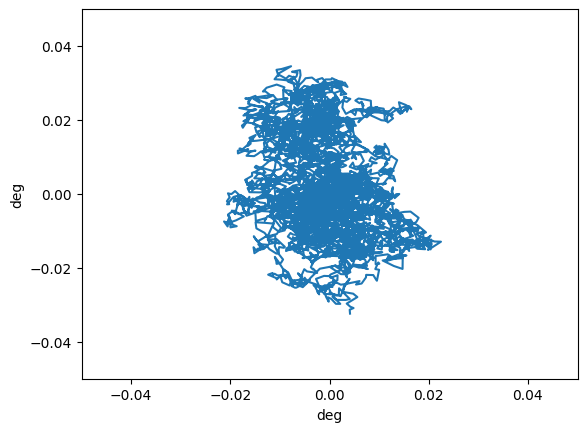

In [110]:
plt.plot(df['q1_s_true'][500:], df['q2_s_true'][500:], label='u1_s')
plt.xlabel('deg')
plt.ylabel('deg')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)


(-0.05, 0.05)

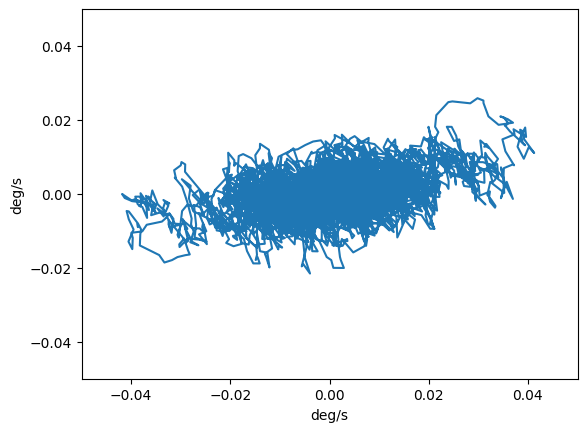

In [111]:
plt.plot(df['dq1_s_true'][500:], df['dq2_s_true'][500:], label='u1_s')
plt.xlabel('deg/s')
plt.ylabel('deg/s')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

(-1.0, 1.0)

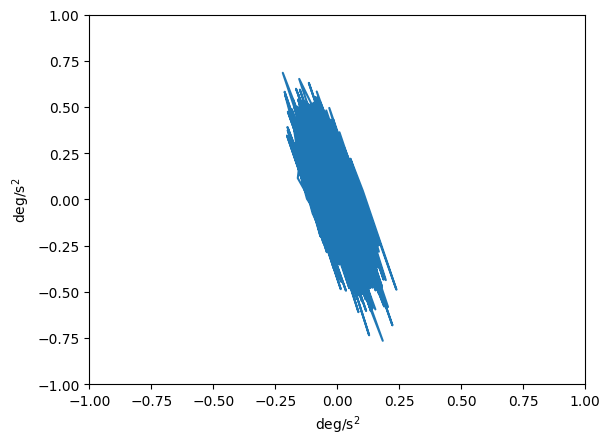

In [118]:
plt.plot(df['ddq1_s_true'][500:], df['ddq2_s_true'][500:], label='u1_s')
plt.xlabel(r'deg/s$^2$')
plt.ylabel(r'deg/s$^2$')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [119]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

# Assuming the user provides the dataframe `df`
# Simulating data loading (randomized for demonstration, should be replaced with actual data)
n_samples = 1000  # Sample size
np.random.seed(42)  # For reproducibility


# Define Butterworth filter
def butterworth_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data)

# Sampling frequency (assumed)
fs = 100  # Hz (adjust as necessary)

morasso = pd.DataFrame()
# Low-pass filter (cutoff 0.5 Hz)
morasso['q1_low'] = butterworth_filter(df['q1_s_true'][500:], 0.5, fs, order=4, filter_type='low')
morasso['q2_low'] = butterworth_filter(df['q2_s_true'][500:], 0.5, fs, order=4, filter_type='low')

# High-pass filter (cutoff 0.9 Hz)
morasso['q1_high'] = butterworth_filter(df['q1_s_true'][500:], 0.9, fs, order=4, filter_type='high')
morasso['q2_high'] = butterworth_filter(df['q2_s_true'][500:], 0.9, fs, order=4, filter_type='high')

# Compute correlation coefficients
low_freq_corr = np.corrcoef(morasso['q1_low'], morasso['q2_low'])[0, 1]  # Expected in-phase
high_freq_corr = np.corrcoef(morasso['q1_high'], morasso['q2_high'])[0, 1]  # Expected anti-phase

# Print results
print(f"Low-frequency correlation (in-phase): {low_freq_corr:.4f}")
print(f"High-frequency correlation (anti-phase): {high_freq_corr:.4f}")


Low-frequency correlation (in-phase): -0.3555
High-frequency correlation (anti-phase): 0.0805


# ALL DF

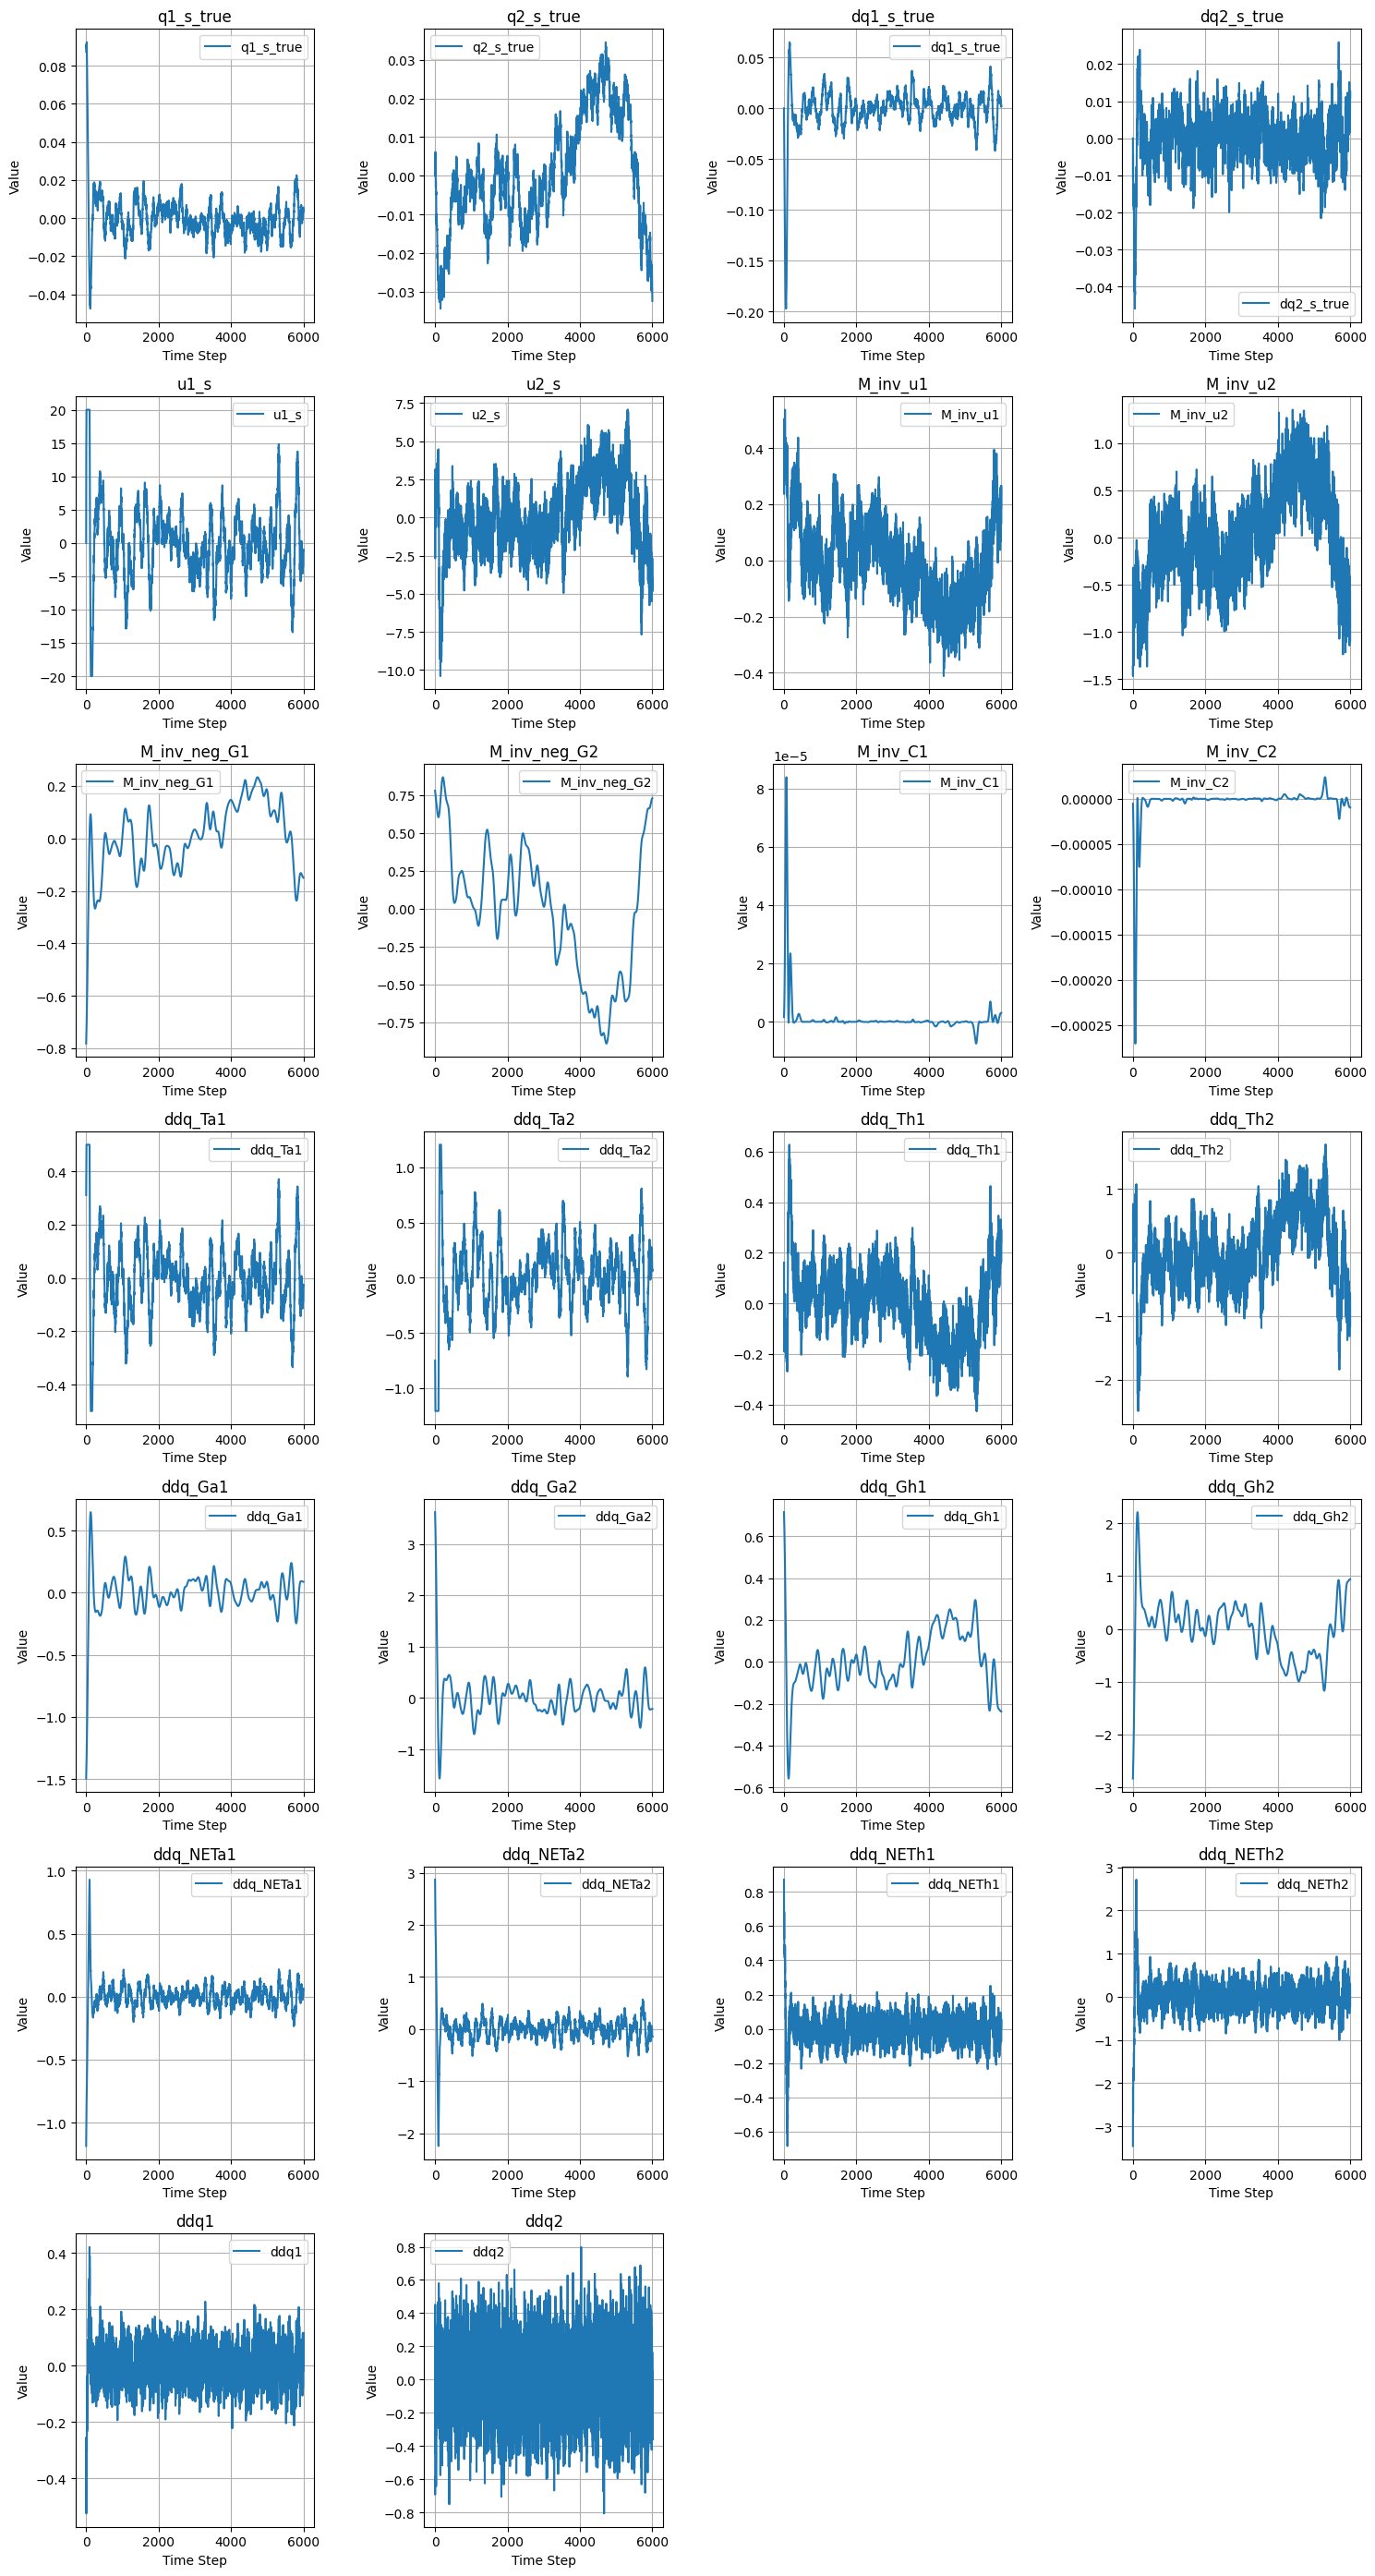

In [36]:
# データフレームのカラム数を取得
num_columns = len(sasagawa.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(sasagawa.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(sasagawa[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()

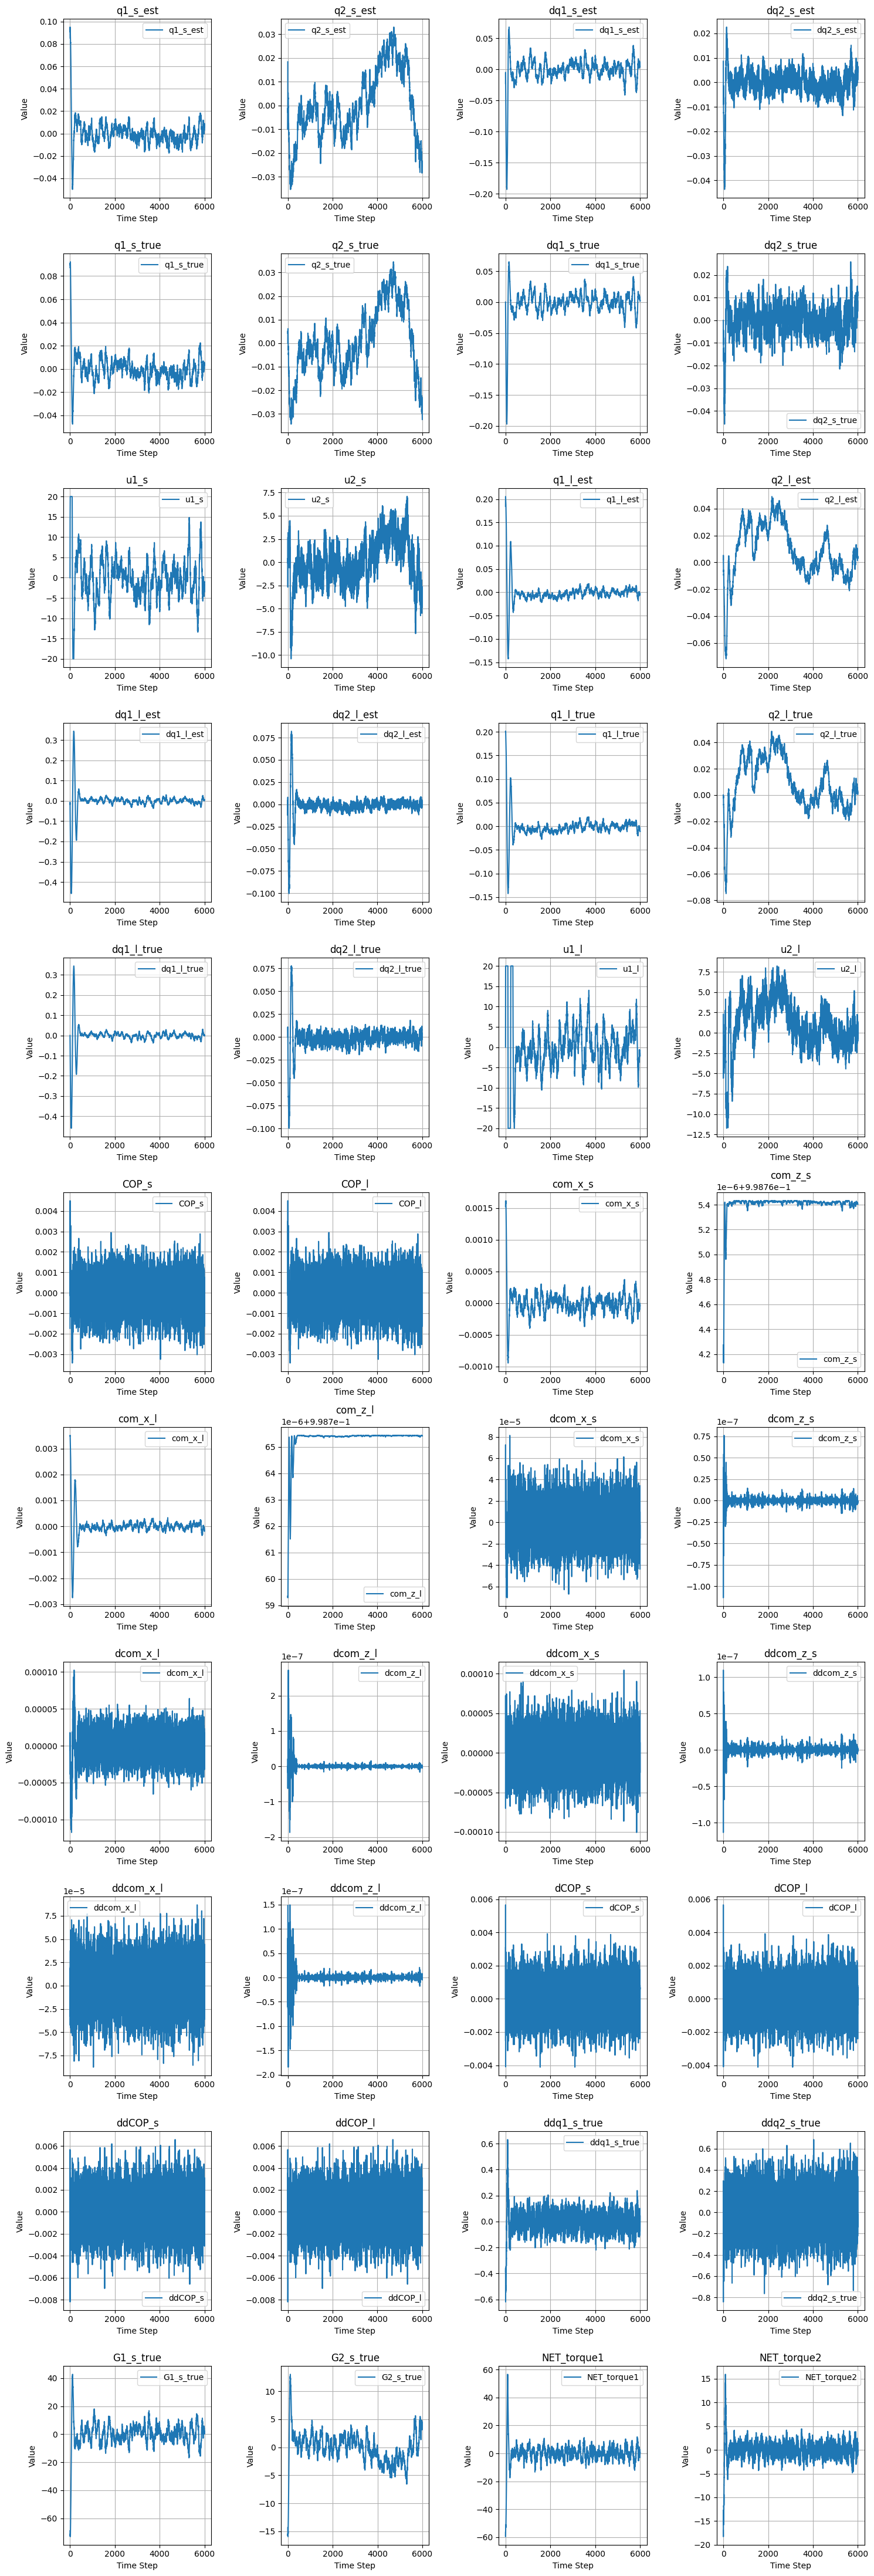

In [37]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()